In [1]:
!pip install textblob nltk


   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   --------------------------------- ------ 524.3/624.3 kB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 624.3/624.3 kB 1.4 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shath\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
import pandas as pd   # pandas is imported with the alias pd
df = pd.read_csv(r"C:\Users\shath\OneDrive\shatha\OneDrive\Desktop\college_event_feedback.csv")


# Basic overview
print(df.shape)
print(df.columns.tolist())
df.head()
df.info()
df.isna().sum()


(20, 5)
['Timestamp', 'Event_Name', 'Department', 'Rating', 'Feedback']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Timestamp   20 non-null     object
 1   Event_Name  20 non-null     object
 2   Department  20 non-null     object
 3   Rating      20 non-null     int64 
 4   Feedback    20 non-null     object
dtypes: int64(1), object(4)
memory usage: 932.0+ bytes


Timestamp     0
Event_Name    0
Department    0
Rating        0
Feedback      0
dtype: int64

In [18]:
df.info()
df.describe()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Timestamp   20 non-null     object
 1   Event_Name  20 non-null     object
 2   Department  20 non-null     object
 3   Rating      20 non-null     int64 
 4   Feedback    20 non-null     object
dtypes: int64(1), object(4)
memory usage: 932.0+ bytes


Timestamp     0
Event_Name    0
Department    0
Rating        0
Feedback      0
dtype: int64

In [7]:
# Keep only the columns you need
keep = ['Event_Name','Department','Rating','Feedback']
df = df[keep].copy()


# Trim strings
for c in ['Event_Name','Department','Feedback']:
    df[c] = df[c].astype(str).str.strip()

# Drop empty feedbacks if you want sentiment only on real text
df = df[df['Feedback'].str.len() > 0]

# Fix ratings
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df = df[df['Rating'].between(1,5)]
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)
print(df.columns.tolist())



['Event_Name', 'Department', 'Rating', 'Feedback']


In [8]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['Feedback'].apply(polarity)
def label(s):
    if s >  0.05: return 'Positive'
    if s < -0.05: return 'Negative'
    return 'Neutral'
df['sentiment_label'] = df['sentiment'].apply(label)
df[['Feedback','sentiment','sentiment_label']].head()


,Feedback,sentiment,sentiment_label
0,Amazing event with great speakers,0.70000,Positive
1,Enjoyed the cultural performances but seating ...,0.17619,Positive
2,Good workshop but timing was not convenient,0.70000,Positive
3,Excellent arrangements and execution,1.00000,Positive
4,Informative but could improve on Q&A session,0.00000,Neutral


In [9]:
summary = {
    "responses": len(df),
    "avg_rating": round(df['Rating'].mean(), 2),
    "pos_%": round((df['sentiment_label'].eq('Positive').mean()*100),1),
    "neu_%": round((df['sentiment_label'].eq('Neutral').mean()*100),1),
    "neg_%": round((df['sentiment_label'].eq('Negative').mean()*100),1),
}
summary


{'responses': 20,
 'avg_rating': np.float64(3.8),
 'pos_%': np.float64(75.0),
 'neu_%': np.float64(10.0),
 'neg_%': np.float64(15.0)}

In [10]:
by_event = (df
    .groupby('Event_Name')
    .agg(responses=('Feedback','count'),
         avg_rating=('Rating','mean'),
         pos_rate=('sentiment_label', lambda s: (s=='Positive').mean()))
    .sort_values(['avg_rating','pos_rate'], ascending=False))
by_event.head(10)


,responses,avg_rating,pos_rate
Event_Name,,,
Tech Fest,8,4.625000,1.000000
Workshop on AI,6,3.833333,0.833333
Cultural Night,6,2.666667,0.333333


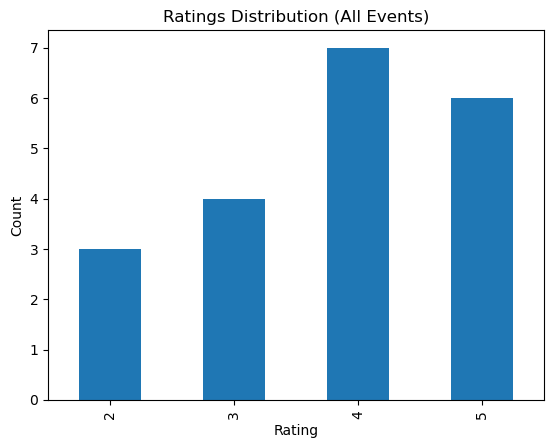

In [11]:
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Ratings Distribution (All Events)')
plt.xlabel('Rating'); plt.ylabel('Count'); plt.show()


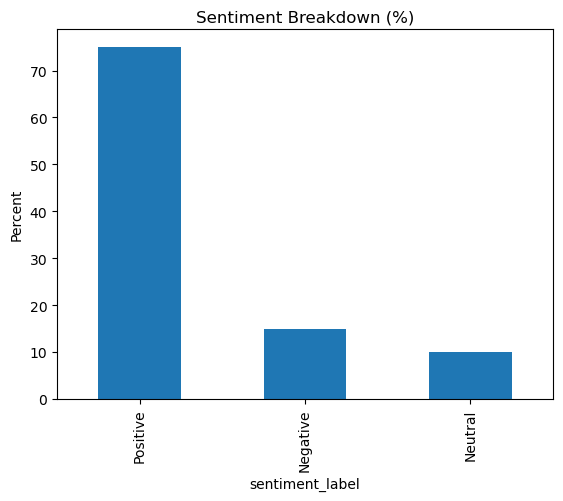

In [12]:
df['sentiment_label'].value_counts(normalize=True).mul(100).plot(kind='bar')
plt.title('Sentiment Breakdown (%)'); plt.ylabel('Percent'); plt.show()


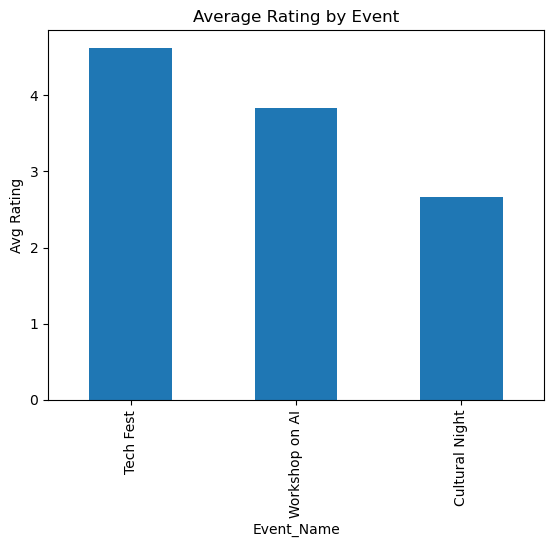

In [13]:
by_event['avg_rating'].plot(kind='bar')
plt.title('Average Rating by Event')
plt.ylabel('Avg Rating'); plt.show()


In [14]:
import re
def has_any(text, keywords):
    text = text.lower()
    return int(any(k in text for k in keywords))

themes = {
    'content': ['content','speaker','talk','topic','session'],
    'logistics': ['registration','queue','entry','seating','arrangement','management'],
    'venue': ['venue','hall','room','auditorium','space','stage'],
    'audio_video': ['mic','sound','audio','speaker system','projector','screen'],
    'food': ['snack','food','refreshment','lunch','catering'],
    'timing': ['time','timing','delay','schedule','late','overrun']
}
for col, keys in themes.items():
    df[f'theme_{col}'] = df['Feedback'].apply(lambda t: has_any(t, keys))

theme_rates = df.filter(like='theme_').mean().sort_values(ascending=False)
theme_rates


theme_content        0.25
theme_logistics      0.10
theme_audio_video    0.10
theme_timing         0.10
theme_venue          0.05
theme_food           0.00
dtype: float64

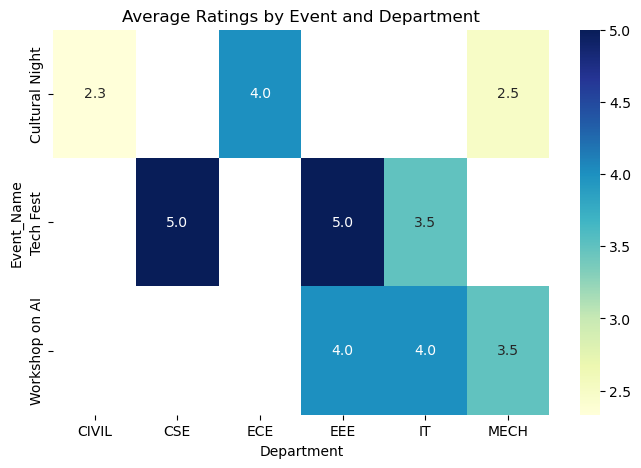

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = df.pivot_table(index="Event_Name", columns="Department", values="Rating", aggfunc="mean")
plt.figure(figsize=(8,5))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Ratings by Event and Department")
plt.show()


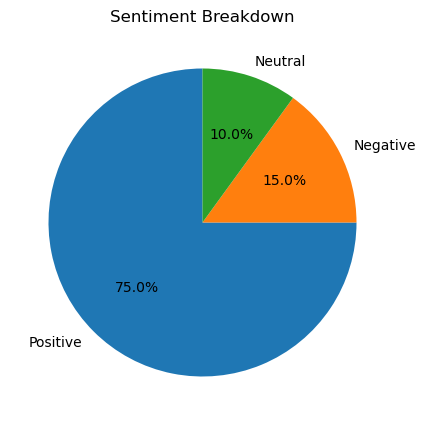

In [17]:
from textblob import TextBlob

# Function to calculate polarity (-1 to +1)
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

# Function to convert polarity to label
def get_sentiment(score):
    if score > 0.05:
        return "Positive"
    elif score < -0.05:
        return "Negative"
    else:
        return "Neutral"

# Apply to Feedback column
df['Sentiment_Score'] = df['Feedback'].apply(get_polarity)
df['Sentiment_Label'] = df['Sentiment_Score'].apply(get_sentiment)

df[['Feedback','Sentiment_Score','Sentiment_Label']].head()

df['Sentiment_Label'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', startangle=90, figsize=(5,5))
plt.title("Sentiment Breakdown")
plt.ylabel("")
plt.show()



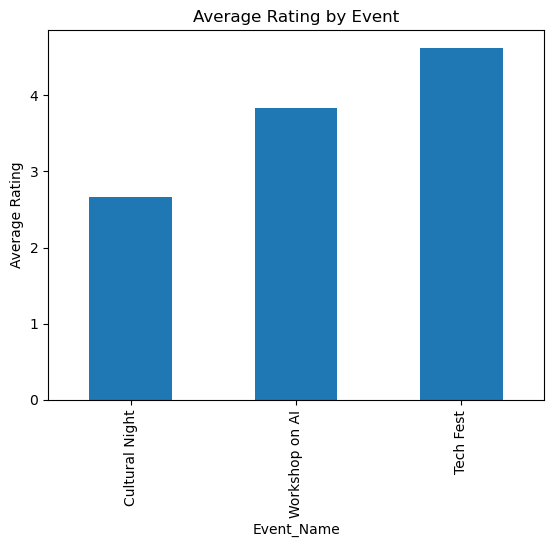

In [18]:
avg_event = df.groupby("Event_Name")["Rating"].mean().sort_values()
avg_event.plot(kind='bar')
plt.title("Average Rating by Event")
plt.ylabel("Average Rating")
plt.show()


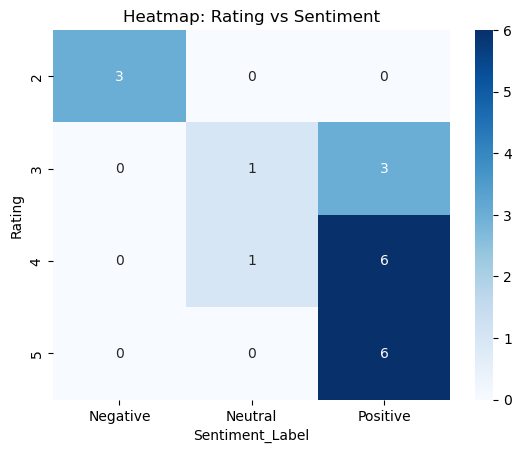

In [19]:
pivot = pd.crosstab(df['Rating'], df['Sentiment_Label'])
sns.heatmap(pivot, annot=True, fmt="d", cmap="Blues")
plt.title("Heatmap: Rating vs Sentiment")
plt.show()
